# Portfolio Generator
This is a portfolio generator for personal portfolio management

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from typing import Union
from sklearn import linear_model, covariance

In [5]:
class Market:
  """Market Class (Abstract)
  
  Params:
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, start: str, end: Union[str, None] = None) -> None:
    self.start = start
    self.end = end
  
  def retrieve_data(self):
    raise NotImplementedError("Data retrieval not implemented")
    
  def calc_stats(self):
    self.calc_risk_free_rate()
    self.calc_volatility()
    
  def calc_risk_free_rate(self):
    raise NotImplementedError("Rf rate not implemented")
    
  def calc_volatility(self):
    raise NotImplementedError("Market volatility not implemented")

  def __str__(self) -> str:
    return f'Market Reference: {self.ticker}\n  Risk-free rate: {self.risk_free_rate}\n  True Volatility: {self.volatility}'

In [6]:
class MarketIndex(Market):
  """Index-based Market Class
  
  Params:
   - ticker: index to track
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, ticker: str,  start: str, end: Union[str, None] = None) -> None:
    self.ticker = ticker
    Market.__init__(self, start, end)
    self.retrieve_data()
    self.calc_stats()
    
  def retrieve_data(self):
    self.data = yf.download(self.ticker, start = self.start, end = self.end, auto_adjust=True)
    self.data = self.data[['Close']].copy()
    self.data.dropna(inplace=True)
    self.data['Return'] = self.data['Close'].pct_change()
    
  def calc_risk_free_rate(self):
    self.risk_free_rate = np.mean(self.data['Return'])
    
  def calc_volatility(self):
    self.volatility = np.std(self.data['Return'])

In [7]:
class MarketFF(Market):
  """Fama-French Data-based Market Class
  
  Params:
   - file: csv file from Ken French's Fama-French database
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, start: str, end: Union[str, None] = None) -> None:
    self.ticker = 'Fama-French'
    Market.__init__(self, start, end)
    self.retrieve_data()
    self.calc_stats()
    
  def retrieve_data(self):
    self.data = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    self.data.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RF']
    self.data['RF'] = self.data['RF'] / 100
    self.data['DATE'] = pd.to_datetime(self.data['DATE'], format='%Y%m%d')
    if self.end is None:
      self.data = self.data[(self.data['DATE'] >= self.start)]
    else:
      self.data = self.data[(self.data['DATE'] >= self.start) & (self.data['DATE'] <= self.end)]
      
  def calc_risk_free_rate(self):
    self.risk_free_rate = np.mean(self.data['RF'])
    
  def calc_volatility(self):
    self.volatility = 0

In [8]:
class Portfolio:
  """Portfolio Class
  
  Params:
   - tickers: the list of stocks to generate the portfolio
   - start: start date to retrieve historical data
   - end: end date to retrieve historical data
  """
  def __init__(self, tickers: list, start: str, end: Union[str, None] = None, data: Union[pd.DataFrame, None] = None) -> None:
    if len(tickers) <= 1:
      raise Exception("Tickers must be a list of at least 2 assets")
    self.tickers = [ticker.upper() for ticker in tickers]
    self.tickers.sort()
    self.start = start
    self.end = end
    self.data = None if data is None else data.copy()
    self.retrieve_data()
    self.calc_stats()
    
  def __str__(self) -> str:
    return f'Portfolio Assets: {self.tickers}\n  Average Return: {self.mean_returns}\n  Expected Return: {self.expected_returns}'
    
  def retrieve_data(self):
    if self.data is None:
      self.data = yf.download(self.tickers, start = self.start, end = self.end, auto_adjust=True)
    else:
      if self.end is None:
        self.data = self.data[(self.data.index >= self.start)]
      else:
        self.data = self.data[(self.data.index >= self.start) & (self.data.index <= self.end)]
    self.data = self.data[['Close']]
    
    returns = self.data[['Close']].pct_change()
    returns.columns = returns.columns.set_levels(['Return'], level=0)
    self.data = pd.concat([self.data, returns], axis=1)
  
  def calc_stats(self):
    self.calc_mean_returns()
    self.calc_expected_returns()
    self.calc_covariance_matrix()
  
  def calc_mean_returns(self):
    self.mean_returns = [np.mean(self.data['Return'][ticker]) for ticker in self.tickers]
    
  def calc_expected_returns(self):
    """Uses the Fama-French 3 Factor Model"""
    returns = self.data['Return'].reset_index().melt(id_vars=["Date"], var_name="ASSET", value_name="RET").dropna()
    returns.columns = ['DATE', 'ASSET', 'RET']
    
    ff3 = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    ff3.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RF']
    ff3['RF'] = ff3['RF'] / 100
    ff3['DATE'] = pd.to_datetime(ff3['DATE'], format='%Y%m%d')
    
    merged = pd.merge(returns, ff3, on="DATE")
    merged["XRET"] = merged["RET"] - merged["RF"]
    grouped = merged.groupby(["ASSET"])

    beta = {'ASSET':[], 'ff3_alpha':[], 'ff3_beta':[], 'smb_beta':[], 'hml_beta':[]}
    ret = {'ASSET': [], 'DATE': [], 'FF3_RET': []}

    for name, group in grouped:
        ff3model = linear_model.LinearRegression().fit(group[["MKTRF", "SMB", "HML"]], group["XRET"])
        
        beta['ASSET'].append(name)
        beta['ff3_alpha'].append(ff3model.intercept_)
        beta['ff3_beta'].append(ff3model.coef_[0])
        beta['smb_beta'].append(ff3model.coef_[1])
        beta['hml_beta'].append(ff3model.coef_[2])
        
        ret['ASSET'].extend([name] * len(group))
        ret['DATE'].extend(group["DATE"])
        ret['FF3_RET'].extend(ff3model.predict(group[["MKTRF", "SMB", "HML"]]) + group["RF"])
        
    self.beta = pd.DataFrame(beta)
    self.beta['ERET'] = self.beta['ff3_alpha'] + self.beta['ff3_beta'] * np.mean(merged['MKTRF']) + self.beta['smb_beta'] * np.mean(merged['SMB']) + self.beta['hml_beta'] * np.mean(merged['HML'])
    self.expected_returns = self.beta['ERET'].to_list()
    
  def calc_covariance_matrix(self):
    """Calculates the covariance matrix using OAS shrinkage"""
    weekly_returns = self.data['Return'].resample('1W').mean().applymap(lambda x: (x + 1)**7 - 1).fillna(0)
    # monthly_returns = self.data['Return'].resample('1M').mean().applymap(lambda x: (x + 1)**30 - 1)
    self.cov_matrix = covariance.oas(weekly_returns)[0]

In [9]:
class MVO:
  """Mean Variance Optimization Class
  
  Params:
   - portfolio: the portfolio to optimize
   - market: the market reference
   - bounds: constraint on the weight of each stock where 1 == 100% and negative means shorting
  """
  def __init__(self, portfolio: Portfolio, market: Market, bounds: Union[list, None] = None) -> None:
    self.portfolio = portfolio
    self.market = market
    self.bounds = bounds
  
  def pf_variance(self, weights):
    return np.dot(weights.T, np.dot(self.portfolio.cov_matrix, weights))
  
  def pf_volatility(self, weights):
    return np.sqrt(self.pf_variance(weights))
  
  def pf_return(self, weights):
    return np.dot(weights.T, self.portfolio.expected_returns)
  
  def pf_return_negate(self, weights):
    return -np.dot(weights.T, self.portfolio.expected_returns)
  
  def pf_sharpe(self, weights, risk_free_rate):
    return -(self.pf_return(weights) - risk_free_rate) / self.pf_volatility(weights)
    
  def pf_utility(self, weights, risk_aversion):
    return -(self.pf_return(weights) - (1 / 2) * risk_aversion * self.pf_volatility(weights))
  
  def minimum_variance(self, expected_return=None):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    if not (expected_return is None):
      constraints.append({"type": "eq", "fun": lambda x: self.pf_return(x) - expected_return})

    result = minimize(fun=self.pf_variance,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": np.sqrt(result.fun)
    }
    
  def maximum_return(self, expected_volatility):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                   {"type": "eq", "fun": lambda x: self.pf_volatility(x) - expected_volatility}]

    result = minimize(fun=self.pf_return_negate,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": -result.fun,
      "Volatility": self.pf_volatility(result.x)
    }
  
  def maximum_sharpe(self):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]

    result = minimize(fun=self.pf_sharpe,
                      x0=init_guess,
                      args=(self.market.risk_free_rate),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": self.pf_volatility(result.x),
      "Sharpe": -result.fun
    }
    
  def maximum_utility(self, risk_aversion=10):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)    

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]

    result = minimize(fun=self.pf_utility,
                      x0=init_guess,
                      args=(risk_aversion),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)

    self.stats = {
      "Weights": result.x,
      "Returns": np.sum(self.portfolio.expected_returns * result.x),
      "Volatility": self.pf_volatility(result.x),
      "Utility": -result.fun
    }
    
  def plot_MVO(self):
    self.minimum_variance()
    returns = np.linspace(self.stats['Returns'] - 0.001, self.stats['Returns'] + 0.002, 51)
    vol = []
    for ret in returns:
      self.minimum_variance(ret)
      vol.append(self.stats["Volatility"])
    plt.plot(vol, returns)
    plt.title('Mean Variance Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()

## Testing

In [10]:
nasdaq100 = open('nasdaq100.txt', 'r').read().split('\n')
dj30 = open('dj30.txt', 'r').read().split('\n')
train_data = dj30
# train_data.remove('GEHC')
# train_data.remove('CEG')
# train_data.remove('GFS')

In [11]:
train_data.sort()

In [12]:
data = yf.download(train_data, "2000-01-01", auto_adjust=True)

[*********************100%***********************]  98 of 98 completed


In [17]:
import datetime as dt
from dateutil.rrule import rrule, MONTHLY
from dateutil.relativedelta import relativedelta

dates = []
for d in rrule(MONTHLY, dtstart=dt.date(2023, 1, 1), until=dt.date(2024, 1, 1)):
  dates.append([(d - relativedelta(months=1)).strftime("%Y-%m-%d"), (d.strftime("%Y-%m-%d")), ((d + relativedelta(months=1)).strftime("%Y-%m-%d"))])

In [18]:
weights = []
for date in dates:
  train_start, train_end, _ = date
  market_train = MarketFF(train_start, train_end)
  portfolio_train = Portfolio(train_data, train_start, train_end, data)
  exp = np.array([0 if exp <= 0 else exp for exp in portfolio_train.expected_returns])
  exp.sum()

In [ ]:
market_test = MarketIndex('^NDX', dates[0][1], dates[-1][1])

[*********************100%***********************]  1 of 1 completed


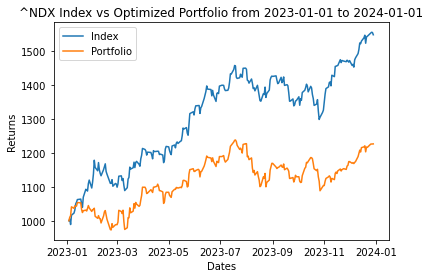

In [ ]:
data_ret = data['Close'].pct_change()[1:]
market_trace = [1000]
for ret in market_test.data['Return'][1:]:
  market_trace.append(market_trace[-1] * (1+ret))

pf_trace_total = []
amt = 1000
for i in range(len(dates) - 1):
  _, start, end = dates[i]
  weight = weights[i]
  pf_trace = data_ret.copy()
  pf_trace = pf_trace[(pf_trace.index >= start) & (pf_trace.index < end)]
  pf_ret = pf_trace.copy()
  pf_trace.iloc[0] = weight
  pf_trace.iloc[0] *= amt

  for idx in pf_trace.index[1:]:
    pf_trace.loc[idx] = pf_trace.shift(1).loc[idx] * (1+pf_trace.loc[idx])
  
  amt = pf_trace.sum(axis=1)[-1]
  pf_trace_total.append(pf_trace.sum(axis=1))
pf_trace_total = pd.concat(pf_trace_total)

plt.plot(market_test.data.index, market_trace, label="Index")
plt.plot(pf_trace_total.index, pf_trace_total.values, label="Portfolio")
plt.title(f'{market_test.ticker} Index vs Optimized Portfolio from {dates[0][1]} to {dates[-1][1]}')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Returns')
plt.show()